In [1]:
import pytorch_lightning as pl
import pytorch_forecasting as pf

print("PyTorch Lightning version:", pl.__version__)
print("PyTorch Forecasting version:", pf.__version__)

PyTorch Lightning version: 2.3.3
PyTorch Forecasting version: 1.0.0


/home/rosh/miniforge3/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [29]:
import xarray as xr
import ocf_blosc2
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import Trainer
import pytorch_lightning as pl
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from pytorch_forecasting.data import NaNLabelEncoder, GroupNormalizer


from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer

from pytorch_forecasting.data import TimeSeriesDataSet, GroupNormalizer


# from pytorch_lightning.tuner.lr_finder import LearningRateFinder


In [3]:
forecast_data = pd.read_csv("result_data/data_tft_36.csv")
print(forecast_data.shape)
forecast_data = forecast_data.drop(columns=['Unnamed: 0'])
forecast_data = forecast_data.sort_values(['ss_id', 'pv_datetime'])
forecast_data['ss_id'] = forecast_data['ss_id'].astype(int)
forecast_data['pv_datetime'] = pd.to_datetime(forecast_data['pv_datetime'])
forecast_data['date'] = forecast_data['pv_datetime'].dt.date
forecast_data['day_of_week'] = forecast_data['pv_datetime'].dt.dayofweek
forecast_data['month'] = forecast_data['pv_datetime'].dt.month


(11952, 26)


In [4]:
forecast_data.head()

,ss_id,init_time,step,generation,pv_datetime,pv_hour,hour,lat,long,tilt,...,sr,t2m,tcc,u10,u100,v10,v100,date,day_of_week,month
5832,2626,2019-02-13 00:00:00,0 days 00:00:00,0.0,2019-02-12 23:00:00,23.0,1.0,54.99,-3.18,22.0,...,0.0,281.21753,0.993683,1.998593,3.772186,3.417703,6.584270,2019-02-12,1,2
5833,2626,2019-02-13 00:00:00,0 days 01:00:00,0.0,2019-02-13 00:00:00,0.0,2.0,54.99,-3.18,22.0,...,0.0,281.70947,0.999939,2.529497,4.472948,4.112045,7.254433,2019-02-13,2,2
5834,2626,2019-02-13 00:00:00,0 days 02:00:00,0.0,2019-02-13 01:00:00,1.0,3.0,54.99,-3.18,22.0,...,0.0,281.86400,0.999786,2.997723,5.072718,4.938729,8.480017,2019-02-13,2,2
5835,2626,2019-02-13 00:00:00,0 days 03:00:00,0.0,2019-02-13 02:00:00,2.0,4.0,54.99,-3.18,22.0,...,0.0,281.76953,0.998024,3.551091,5.737916,6.641625,10.684008,2019-02-13,2,2
5836,2626,2019-02-13 00:00:00,0 days 04:00:00,0.0,2019-02-13 03:00:00,3.0,5.0,54.99,-3.18,22.0,...,0.0,281.46997,0.999996,3.081366,5.090918,6.080827,9.852675,2019-02-13,2,2


In [5]:
forecast_data.columns

Index(['ss_id', 'init_time', 'step', 'generation', 'pv_datetime', 'pv_hour',
       'hour', 'lat', 'long', 'tilt', 'orientation', 'dlwrf', 'dswrf', 'duvrs',
       'hcc', 'lcc', 'mcc', 'sde', 'sr', 't2m', 'tcc', 'u10', 'u100', 'v10',
       'v100', 'date', 'day_of_week', 'month'],
      dtype='object')

In [6]:
target_variable = 'generation'
static_features = ['ss_id', 'lat', 'long', 'tilt', 'orientation']
known_future_inputs = [
    'dlwrf', 'dswrf', 'duvrs', 'hcc', 'lcc', 'mcc', 'sde', 'sr', 
    't2m', 'tcc', 'u10', 'u100', 'v10', 'v100', 'day_of_week', 'month', 'hour'
]

required_columns = static_features + known_future_inputs + [target_variable, 'pv_datetime', 'date']

forecast_data = forecast_data[required_columns]

forecast_data = forecast_data.fillna(method='bfill').fillna(method='ffill')

forecast_data['time_idx'] = forecast_data.index

In [7]:
print(forecast_data.columns)

forecast_data.dtypes

Index(['ss_id', 'lat', 'long', 'tilt', 'orientation', 'dlwrf', 'dswrf',
       'duvrs', 'hcc', 'lcc', 'mcc', 'sde', 'sr', 't2m', 'tcc', 'u10', 'u100',
       'v10', 'v100', 'day_of_week', 'month', 'hour', 'generation',
       'pv_datetime', 'date', 'time_idx'],
      dtype='object')


ss_id                   int64
lat                   float64
long                  float64
tilt                  float64
orientation           float64
dlwrf                 float64
dswrf                 float64
duvrs                 float64
hcc                   float64
lcc                   float64
mcc                   float64
sde                   float64
sr                    float64
t2m                   float64
tcc                   float64
u10                   float64
u100                  float64
v10                   float64
v100                  float64
day_of_week             int32
month                   int32
hour                  float64
generation            float64
pv_datetime    datetime64[ns]
date                   object
time_idx                int64
dtype: object

In [8]:
forecast_data.head()

,ss_id,lat,long,tilt,orientation,dlwrf,dswrf,duvrs,hcc,lcc,...,u100,v10,v100,day_of_week,month,hour,generation,pv_datetime,date,time_idx
5832,2626,54.99,-3.18,22.0,270.0,0.0,0.0,0.0,0.840149,0.972809,...,3.772186,3.417703,6.584270,1,2,1.0,0.0,2019-02-12 23:00:00,2019-02-12,5832
5833,2626,54.99,-3.18,22.0,270.0,1253060.9,0.0,0.0,0.989410,0.996460,...,4.472948,4.112045,7.254433,2,2,2.0,0.0,2019-02-13 00:00:00,2019-02-13,5833
5834,2626,54.99,-3.18,22.0,270.0,2522292.0,0.0,0.0,0.995789,0.986664,...,5.072718,4.938729,8.480017,2,2,3.0,0.0,2019-02-13 01:00:00,2019-02-13,5834
5835,2626,54.99,-3.18,22.0,270.0,3796621.0,0.0,0.0,0.992706,0.988342,...,5.737916,6.641625,10.684008,2,2,4.0,0.0,2019-02-13 02:00:00,2019-02-13,5835
5836,2626,54.99,-3.18,22.0,270.0,5051079.0,0.0,0.0,0.995605,0.999664,...,5.090918,6.080827,9.852675,2,2,5.0,0.0,2019-02-13 03:00:00,2019-02-13,5836


In [9]:
# forecast_data.to_csv("test2.csv")

In [10]:
max_encoder_length = 36
max_prediction_length = 36

- keep it continous
- let's just do 36 hours
- check the minimum, 36, if not remove it. 
- init time 2 adjacent values has 12 hours gap. 
- use only 36 steps
- even if nwp data is missing, it is fine to give nans. model will learn
- start with 36 hours forecast
- select a lot from pv, get rid of nans, and get it for training for next steps

- pick one specific datetime , make a graph, one forecast batch, look what clouds are doing, what generation is like, 

In [11]:
training_cutoff = forecast_data["pv_datetime"].max() - pd.Timedelta(hours=max_prediction_length)
training_cutoff

Timestamp('2021-10-26 11:00:00')

In [12]:
training_data = forecast_data[forecast_data["pv_datetime"] <= training_cutoff]
num_training_rows = len(training_data)
print(f"Number of rows in the training set: {num_training_rows}")
print(forecast_data.shape)

Number of rows in the training set: 11772
(11952, 26)


In [13]:
forecast_data['ss_id'] = forecast_data['ss_id'].astype(str)
forecast_data['day_of_week'] = forecast_data['day_of_week'].astype(str)
forecast_data['month'] = forecast_data['month'].astype(str)
forecast_data['hour'] = forecast_data['hour'].astype(str)


In [14]:
print("Total rows in forecast_data:", len(forecast_data))
print("Rows before training_cutoff:", len(forecast_data[forecast_data.pv_datetime <= training_cutoff]))
print("Training cutoff datetime:", training_cutoff)


Total rows in forecast_data: 11952
Rows before training_cutoff: 11772
Training cutoff datetime: 2021-10-26 11:00:00


In [15]:
# # Function to check if sequence is continuous and of required length
# def is_continuous_block(df, block_size=48):
#     if len(df) != block_size:
#         return False
#     time_diffs = df['pv_datetime'].diff().dropna()
#     return all(time_diffs == pd.Timedelta(hours=1))

# # Filter sequences to ensure continuity and correct length
# filtered_data = []
# for ss_id, group in forecast_data.groupby('ss_id'):
#     for start_idx in range(0, len(group) - max_encoder_length + 1):
#         block = group.iloc[start_idx:start_idx + max_encoder_length]
#         if is_continuous_block(block, max_encoder_length):
#             filtered_data.append(block)

# filtered_data = pd.concat(filtered_data)
# print("Rows after filtering short and discontinuous sequences:", len(filtered_data))


In [16]:
training = TimeSeriesDataSet(
    forecast_data[lambda x: x.pv_datetime <= training_cutoff],
    time_idx="time_idx",
    target="generation",
    group_ids=["ss_id"],  # Grouping by ss_id to identify different PV sites
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["ss_id"],  # ss_id is static for each site
    static_reals=["lat", "long", "tilt", "orientation"],
    time_varying_known_categoricals=["day_of_week", "month", "hour"],
    time_varying_known_reals=["dlwrf", "dswrf", "duvrs", "hcc", "lcc", "mcc", "sde", "sr", "t2m", "tcc", "u10", "u100", "v10", "v100"],
    time_varying_unknown_reals=["generation"],
    target_normalizer=GroupNormalizer(groups=["ss_id"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=False,
)


In [17]:
# forecast_data.dtypes

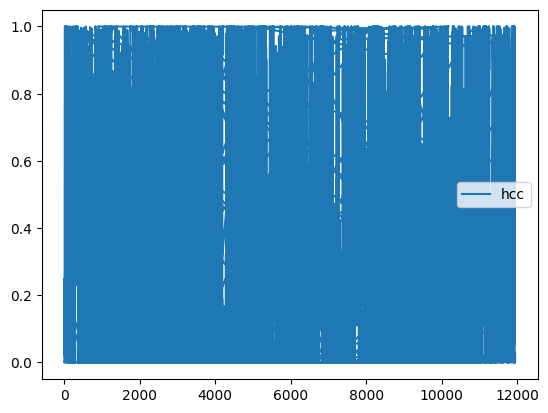

In [18]:
plot_cols = ['hcc']
plot_features = forecast_data[plot_cols]

p = plot_features.plot(subplots=True)
plot_features = forecast_data[plot_cols][:]

In [19]:
# forecast_data.info()

In [20]:
# forecast_data.head(36)

In [21]:
# create validation dataset using the same normalization techniques as for the training dataset
validation = TimeSeriesDataSet.from_dataset(training, forecast_data, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)


In [22]:
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

In [23]:
# create PyTorch Lighning Trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()


In [24]:
trainer = pl.Trainer(
    max_epochs=50,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # 30 batches per epoch
    callbacks=[lr_logger, early_stop_callback],
    logger=False
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [25]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

In [26]:
print(type(tft))
print(issubclass(TemporalFusionTransformer, pl.LightningModule))  # Should print True


<class 'pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer'>
False


In [27]:
# res = trainer.tuner.lr_find(
#      tft,
#      train_dataloaders=train_dataloader,
#      val_dataloaders=val_dataloader,
#      max_lr=30.0,
#      min_lr=1e-6,
#  )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

In [28]:
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

TypeError: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `TemporalFusionTransformer`

In [28]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

IsADirectoryError: [Errno 21] Is a directory: '/home/rosh/gsoc-data'